# Breast Cancer
Buat model regresi logistik dengan 3 fitur, yang akan memberikan score tertinggi.


## Referensi
1. https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
2. https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/
3. https://medium.com/@amitg0161/sklearn-linear-regression-tutorial-with-boston-house-dataset-cde74afd460a
4. https://discuss.analyticsvidhya.com/t/how-does-the-recursive-feature-elimination-rfe-works-and-how-it-is-different-from-backward-elimination/74199

## Exploratory Data Analysis dan Preprocessing
Hal yang pertama harus dilakukan adalah me-load dataset Breast Cancer dari scikit-learn.

In [0]:
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.preprocessing import MinMaxScaler 
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
cancer = datasets.load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [0]:
print(cancer.feature_names, len(cancer.feature_names))

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'] 30


In [0]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['diagnosis'] = cancer.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Kemudian, lakukan normalisasi pada dataset:

In [0]:
x = df.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=df.columns)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,0.356147,0.120469,0.369034,0.273811,0.159296,0.351398,0.135682,0.300625,0.311645,0.183042,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0.0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,0.156437,0.082589,0.124440,0.125660,0.119387,0.081323,0.046970,0.253836,0.084539,0.091110,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0.0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,0.229622,0.094303,0.180370,0.162922,0.150831,0.283955,0.096768,0.389847,0.205690,0.127006,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0.0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,0.139091,0.175875,0.126655,0.038155,0.251453,0.543215,0.142955,0.353665,0.728148,0.287205,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0.0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,0.233822,0.093065,0.220563,0.163688,0.332359,0.167918,0.143636,0.357075,0.136179,0.145800,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0.0


Dataset breast cancer terdiri atas 30 fitur. Berikut adalah grafik yang menggambarkan korelasi antar fitur dan korelasi fitur dengan diagnosis. Dapat dilihat fitur yang urutannya berdekatan memiliki korelasi yang cukup tinggi. Selain itu, korelasi fitur dengan diagnosis sebagian besar memiliki nilai negatif, kurang dari -0.5.

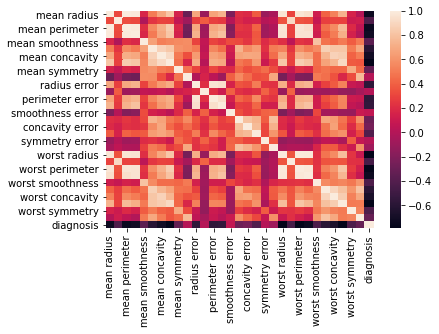

In [0]:
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix)

Berikut adalah plot histogram dari nilai semua fitur pada dataset.

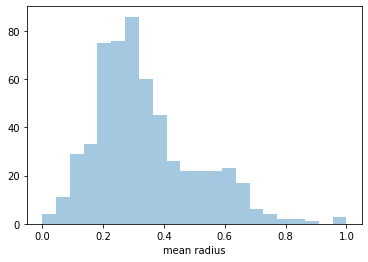

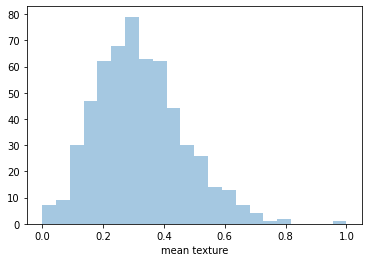

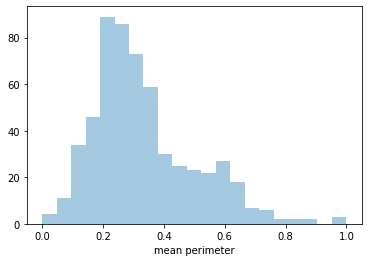

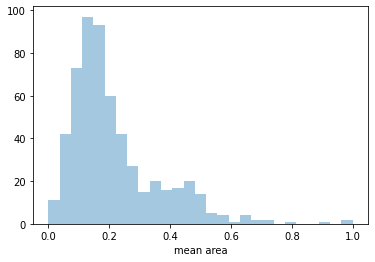

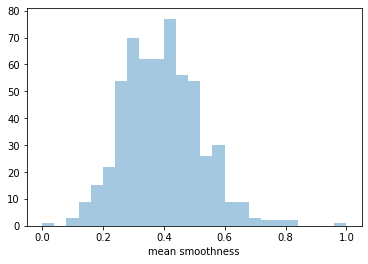

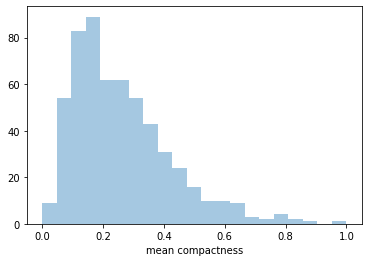

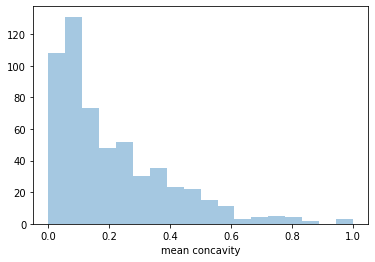

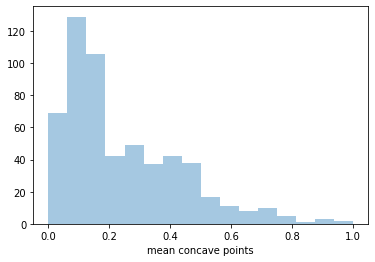

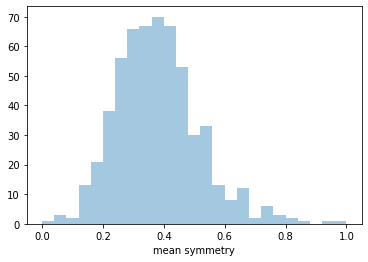

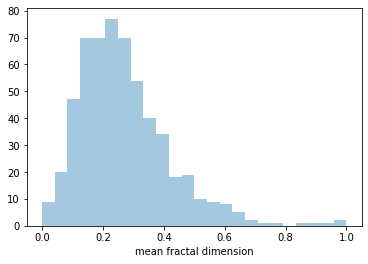

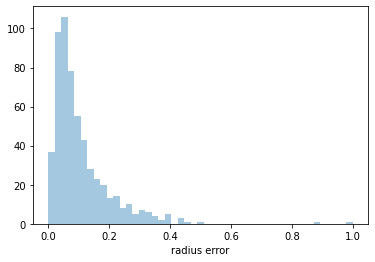

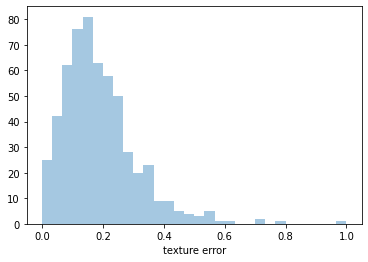

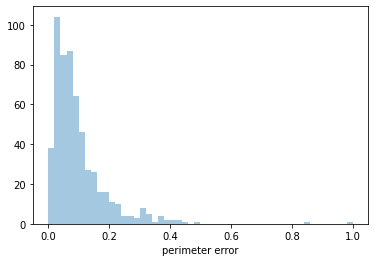

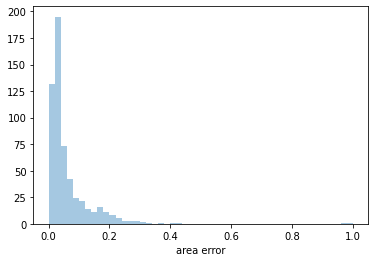

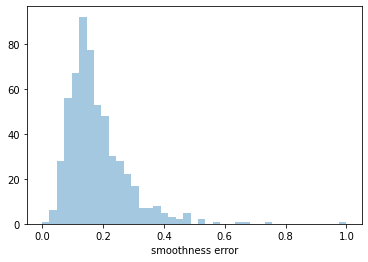

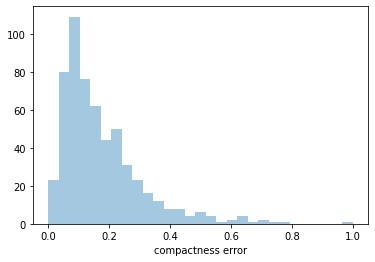

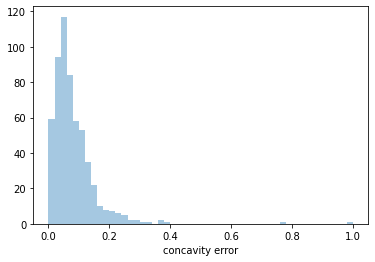

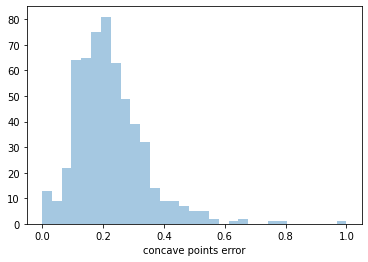

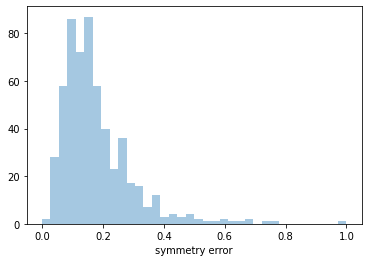

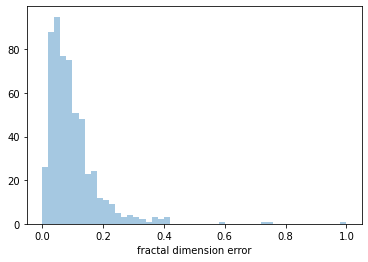

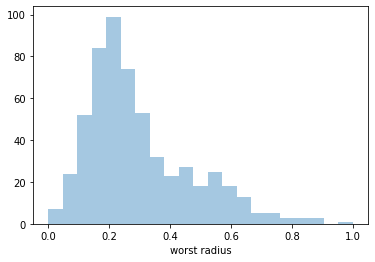

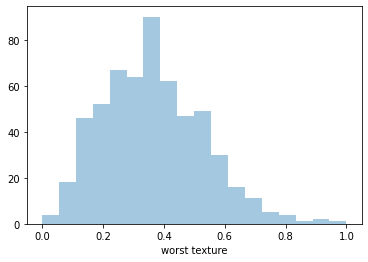

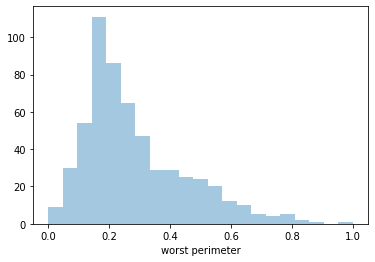

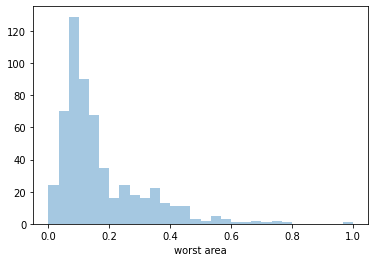

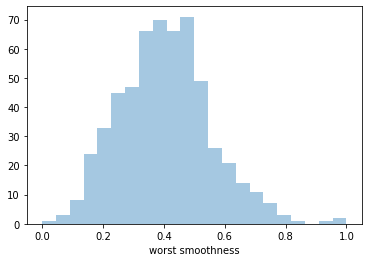

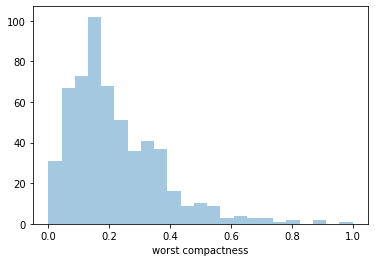

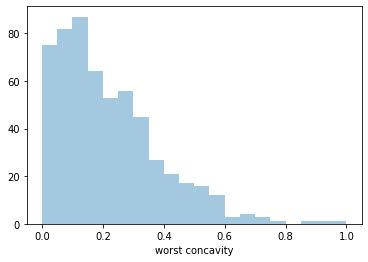

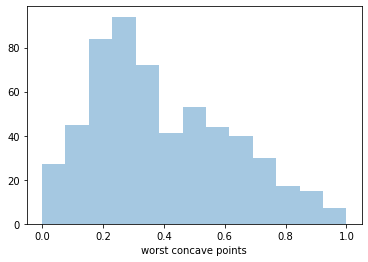

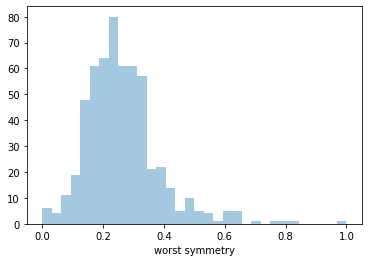

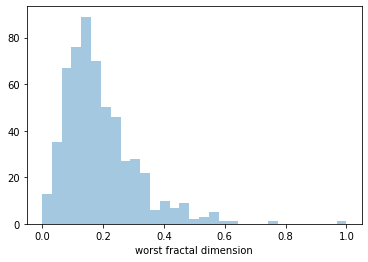

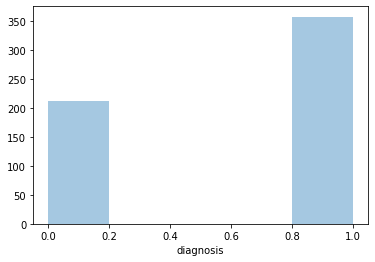

In [0]:
for col in df.columns:
  plt.figure()
  sns.distplot(df[col], kde=False)
  plt.show()

## Regresi Logistik dengan Semua Feature
Dengan semua fitur, diperoleh score 0.98.

In [0]:
X = df.drop('diagnosis', 1)
y = df['diagnosis']

In [0]:
model = LogisticRegression(max_iter=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9824561403508771

Confusion Matrix:

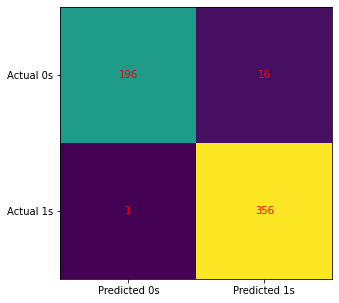

In [0]:
conf_mat = confusion_matrix(y, model.predict(X))
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(conf_mat)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='red')
plt.show()

Classification Report:

In [0]:
class_report = classification_report(y, model.predict(X))
print('classification report:\n', class_report)

classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.92      0.96       212
         1.0       0.96      1.00      0.98       357

    accuracy                           0.97       569
   macro avg       0.98      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569



## Feature Selection dengan Recursive Feature Elimination
Untuk pemilihan fitur, disini digunakan algoritma RFE (Recursive Feature Elimination). RFE bekerja secara iteratif, mengurangi fitur satu per satu. Pada tiap iterasi, model dilatih ulang. Fitur pada iterasi yang dinilai paling tidak penting, akan dihilangkan pada iterasi selanjutnya. Iterasi akan terus berlanjut sampai banyak fitur yang tersisa sudah sesuai banyak yang diinginkan. Scikit-learn menyediakan fitur RFE, yang disini akan digunakan.

In [0]:
from sklearn.feature_selection import RFE

print(X.shape, y.shape)
lr = LogisticRegression(max_iter=10000)

# Rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, 3)
rfe.fit(X,y)

# # model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

(569, 30) (569,)
[False False False False False False False False False False False False
 False False False False False False False False  True False  True False
 False False False  True False False]
[ 6 10  4  9 18 22 13  2 21 16 12 28 14 15 27 20 24 25 26 19  1  3  1  5
  7 17  8  1 11 23]


Output RFE di atas menunjukkan kolom mana yang terpilih, dari kolom mana yang menjadi bernilai 1. Untuk memperoleh list kolom yang terpilih, digunakan kode di bawah:

In [0]:
cols = list(X.columns)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['worst radius', 'worst perimeter', 'worst concave points'], dtype='object')


In [0]:
Xpr_cols = list(selected_features_rfe)
Xpr = df[Xpr_cols]
Xpr.head()

,worst radius,worst perimeter,worst concave points
0,0.620776,0.668310,0.912027
1,0.606901,0.539818,0.639175
2,0.556386,0.508442,0.835052
3,0.248310,0.241347,0.884880
4,0.519744,0.506948,0.558419


In [0]:
Xpr.isnull().any()

worst radius            False
worst perimeter         False
worst concave points    False
dtype: bool

Dapat dilihat bahwa fitur yang terpilih adalah :
1. Worst Radius
2. Worst Perimeter
3. Worst Concave Points

Berikut adalah visualisasi dari fitur yang terpilih:

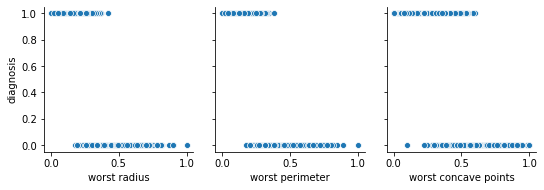

In [0]:
sns.pairplot(df, x_vars=Xpr_cols,y_vars=['diagnosis'])

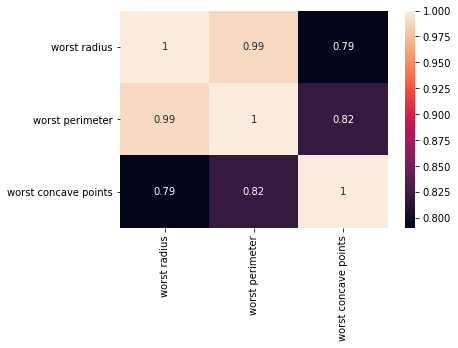

In [0]:
correlation_matrix = Xpr.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

Fitur-fitur yang dipilih RFE ternyata cukup berkorelasi.

## Melatih Model dengan fitur yang tereduksi
Dengan 3 fitur tersebut, diperoleh score 0.94.

In [0]:
model = LogisticRegression(max_iter=10000)
X_train, X_test, y_train, y_test = train_test_split(Xpr, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9385964912280702

Classification report:

In [0]:
class_report = classification_report(y, model.predict(Xpr))
print('classification report:\n', class_report)

classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.86      0.92       212
         1.0       0.92      0.99      0.96       357

    accuracy                           0.94       569
   macro avg       0.95      0.93      0.94       569
weighted avg       0.94      0.94      0.94       569



Confusion Matrix:

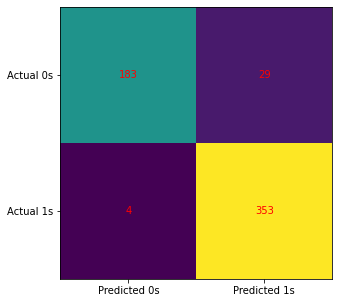

In [0]:
conf_mat = confusion_matrix(y, model.predict(Xpr))
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(conf_mat)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='red')
plt.show()